In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cvxpy as cp

from safety_formation.formation import Agent,Topology
from safety_formation.control_law.nominal import CentralizedFormationControl


## Topology

<Axes: title={'center': 'Topology (Leader=0, Followers=1..N)'}>

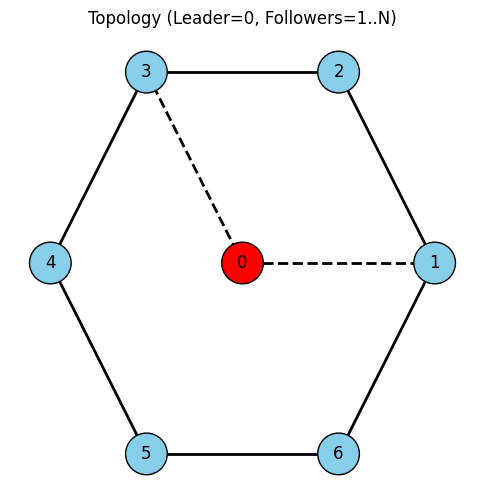

In [3]:
adj_matrix = np.array([
    [0, 1, 0, 0, 0, 1],
    [1, 0, 1, 0, 0, 0],
    [0, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 0],
    [0, 0, 0, 1, 0, 1],
    [1, 0, 0, 0, 1, 0],
], dtype=float)

leader_access = [1, 0, 1, 0, 0, 0]

topo = Topology(num_agents=6, adjacency_matrix=adj_matrix, leader_access=leader_access)

topo.plot()

## Agent creation

In [4]:
# Define formation offsets (f_i) for each follower
f1 = [1, 0, 0, 0]
f2 = [1/2, np.sqrt(3)/2, 0, 0]
f3 = [-1/2, np.sqrt(3)/2, 0, 0]
f4 = [-1, 0, 0, 0]
f5 = [-1/2, -np.sqrt(3)/2, 0, 0]
f6 = [1/2, -np.sqrt(3)/2, 0, 0]

f_list = [f1, f2, f3, f4, f5, f6]

print(np.array(f_list)[:,:2])
print("\n")

# Agent creation (N = 6)
N = 6

# Initial states (x0) for each agent: [x, y, vx, vy]
x0_0 = [0, 0, 0.5, 0]
x1_0 = [-2, 0, -0.5, 0]
x2_0 = [0, 2, 0.2, -0.2]
x3_0 = [0, 1, 1, 0]
x4_0 = [2, 2, 0, 0]
x5_0 = [0, -2, 0, 1]
x6_0 = [2, -2, 0.3, 0]

xi_0_list = [x0_0, x1_0, x2_0, x3_0, x4_0, x5_0, x6_0]

leader = Agent(agent_id=0, x0=x0_0, f_target=[0, 0, 0, 0])  # Leader has no formation offset
agents = []
for i in range(N):
    agents.append(Agent(agent_id=i+1, x0=xi_0_list[i+1], f_target=f_list[i]))

for agent in agents:
    print(f"Agent {agent.id} Initial state: \n {agent.state}, \n Formation offset: \n {agent.f} \n")

[[ 1.         0.       ]
 [ 0.5        0.8660254]
 [-0.5        0.8660254]
 [-1.         0.       ]
 [-0.5       -0.8660254]
 [ 0.5       -0.8660254]]


Agent 1 Initial state: 
 [[-2. ]
 [ 0. ]
 [-0.5]
 [ 0. ]], 
 Formation offset: 
 [[1.]
 [0.]
 [0.]
 [0.]] 

Agent 2 Initial state: 
 [[ 0. ]
 [ 2. ]
 [ 0.2]
 [-0.2]], 
 Formation offset: 
 [[0.5      ]
 [0.8660254]
 [0.       ]
 [0.       ]] 

Agent 3 Initial state: 
 [[0.]
 [1.]
 [1.]
 [0.]], 
 Formation offset: 
 [[-0.5      ]
 [ 0.8660254]
 [ 0.       ]
 [ 0.       ]] 

Agent 4 Initial state: 
 [[2.]
 [2.]
 [0.]
 [0.]], 
 Formation offset: 
 [[-1.]
 [ 0.]
 [ 0.]
 [ 0.]] 

Agent 5 Initial state: 
 [[ 0.]
 [-2.]
 [ 0.]
 [ 1.]], 
 Formation offset: 
 [[-0.5      ]
 [-0.8660254]
 [ 0.       ]
 [ 0.       ]] 

Agent 6 Initial state: 
 [[ 2. ]
 [-2. ]
 [ 0.3]
 [ 0. ]], 
 Formation offset: 
 [[ 0.5      ]
 [-0.8660254]
 [ 0.       ]
 [ 0.       ]] 



## Gain Calculation

In [5]:
# 1. Load System Matrices
A = np.array(leader.A)
B = np.array(leader.B)
n = A.shape[0]

# 2. Compute the coupling strength threshold (delta)
# delta corresponds to the smallest real eigenvalue of the Augmented Laplacian matrix
H = topo.get_augmented_laplacian()  # shape: (N x N)
delta = np.min(np.real(np.linalg.eigvals(H)))

# 3. Define the optimization variable
# Q = inv(P). We use a symmetric variable to represent the Lyapunov candidate
Q = cp.Variable((n, n), symmetric=True)

# 4. Formulate the Linear Matrix Inequality (LMI)
# Based on the Schur Complement of the algebraic Riccati-like inequality
# term1: A*Q + Q*A' - 2*delta*B*B'
term1 = A @ Q + Q @ A.T - 2 * delta * B @ B.T

# Construct the block matrix for the LMI
LMI_block = cp.bmat([
    [term1,                  Q],
    [Q,      -np.eye(n) / delta]
])

# Define constraints:
# 1. The block matrix must be negative definite (LMI << 0)
# 2. Q must be positive definite (Q >> 0)
# We use a small epsilon (1e-6) to enforce strict inequality
constraints = [
    LMI_block << -1e-6 * np.eye(2 * n),
    Q >> 1e-6 * np.eye(n)
]

# 5. Define the Problem and Solve
# Optimization Goal: Minimize trace(Q) to prevent the solver from 
# finding unnecessarily large values (regularization).
prob = cp.Problem(cp.Minimize(0), constraints) 

# CVXOPT is generally more accurate for small-to-medium LMI problems than SCS
prob.solve(solver=cp.CVXOPT, verbose=True)

# 6. Extract results and compute Gain Matrix K
if prob.status == cp.OPTIMAL:
    Q_val = Q.value
    P = np.linalg.inv(Q_val)
    # The control gain is derived from the Lyapunov matrix P
    K = B.T @ P 
    print("Feedback Gain Matrix K:\n", K)
else:
    print("LMI infeasible. Please check system stabilizability or delta value.")

(CVXPY) Feb 28 02:49:10 AM: Your problem has 16 variables, 80 constraints, and 0 parameters.
(CVXPY) Feb 28 02:49:10 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Feb 28 02:49:10 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Feb 28 02:49:10 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) Feb 28 02:49:10 AM: Your problem is compiled with the CPP canonicalization backend.
(CVXPY) Feb 28 02:49:10 AM: Compiling problem (target solver=CVXOPT).
(CVXPY) Feb 28 02:49:10 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing -> CVXOPT
(CVXPY) Feb 28 02:49:10 AM: Applying reduction Dcp2Cone
(CVXPY) Feb 28 02:49:10 AM: Applying reduction CvxAttr2Constr
(CVXPY) Feb 28 02:49:10 AM: Applying reduction ConeMatrixStuffing
(CVXPY) Feb 28 02:49:10 AM: Applying reduction CVXOPT
(CVXPY) Feb 28 02:49:10 AM: Finished problem compilation (t

                                     CVXPY                                     
                                     v1.8.1                                    
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
-------------------------------------------------------------------------------
                                Numerical solver                               
-------------------------------------------------------------------------------
     pcost       dcost       gap    pres   dres   k/t
 0:  0.0000e+00 -1.7407e+01  3e+01  4e-01  3e+00  1e+00
 1:  0.0000e+00 -7.4724e-01  1e+00  2e-02  2e-01  7e-02
 2:  0.0000e+00 -1.1798e-02  1e-02  3e-04  2e-03  1e-03
 3:  0.0000e+00 -1.1780e-04  1e-04  3e-06  2e-05  1e-05
 4:  0.0000e+00 -1.1780e-06  1e-06  3e-08  2e-07  1e-07
 5:  0.0000e+00 -1.1780e-0

In [6]:
K_prime = np.zeros_like(K)  # No leader feedforward in this example
K = np.array([
        [1.6978, -0.0004, 3.9308, 0.0005],
        [0.0002, 1.6966, 0.0005, 3.9309],
    ], dtype=float)

## Simulation

In [7]:
from utils import ErrorTracker, compute_delta_norms
from utils import plot_formation_error, plot_relative_trajectories, plot_world_trajectories

controller = CentralizedFormationControl(K_matrix=K, K_prime_matrix=K_prime)
tracker = ErrorTracker()

dt = 0.01
T = 10.0
steps = int(T / dt)

for k in range(steps):

    # ---- Controller (centralized) ----
    U = controller.compute_nominal(
        all_agents=agents,
        topology=topo,
        leader_state=leader.state
    )  # shape (N,2)

    # ---- Apply control to each follower ----
    for i, ag in enumerate(agents):
        ag.update_physics(U[i], dt)

    # ---- Leader dynamics (optional) ----
    # Ví dụ leader constant velocity:
    leader.update_physics([0, 0], dt)

    # ---- Track error ----
    tracker.step(agents, leader.state)

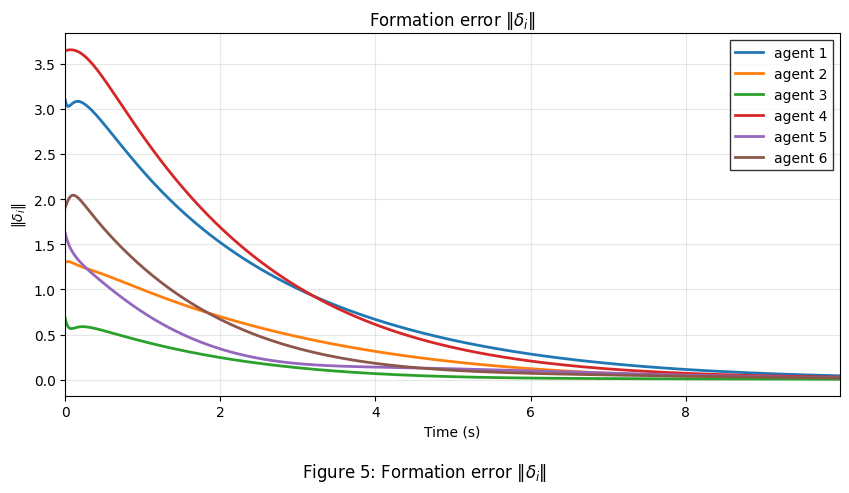

In [8]:
dt = 0.01
norms = compute_delta_norms(agents, leader, use_pos_only=False)  # dùng 4D error
# hoặc use_pos_only=True nếu paper chỉ xét position error

plot_formation_error(
    norms,
    dt=dt,
    caption=r"Figure 5: Formation error $\|\delta_i\|$"
)

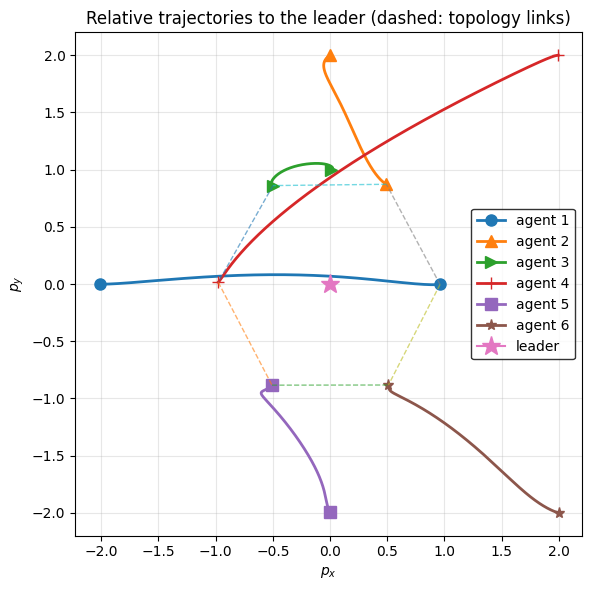

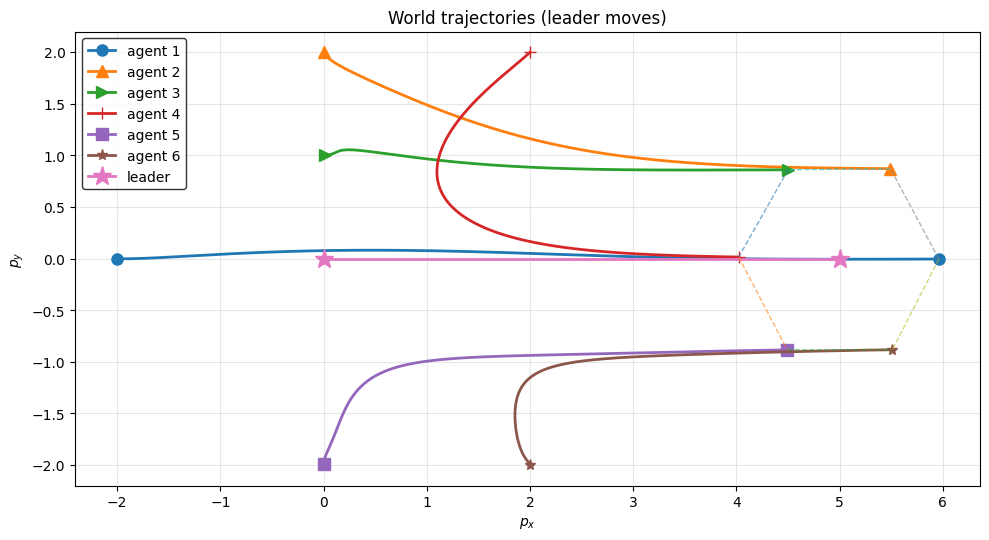

In [9]:
plot_relative_trajectories(agents, leader, topo, show_topology_at="final")
plot_world_trajectories(agents, leader, topo, topology_at="final")